In [5]:
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.utils import resample

## Error functions

In [6]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Exercise 1: OLS on the Franke function
- Mathematical interpretation of OLS: OLS is a projection of the original target vector, y, onto your prediction, $\tilde{y}$, by a matrix $\beta$, which is defined by the coulumn vectors of your matrix X.

## Notes on scaling:
- In this Franke function, x and y is already scaled between 0 and 1
- The function does not vary very much (without noise)
- Recomendation from Morten: Do it yourself. Take design matrix and subtract the mean values, before or after train-test-split
- Scale y as well, y -> y - mean(y), $\beta_0$ = mean(y)

## Results 
- As expected, scaling does not make any significant difference on the mse and $r^2$
- MSE error with noise (mean=0, sigma=1) and N=1000 shrinks from 1.025 to 1 for both test and train
- MSE error without noise and N=1000 shrinks from 0.0225 to 0.0025 for both test and train
- Using low N (~10) can give increased test error, but becomes random each time

## Make Franke function and plot

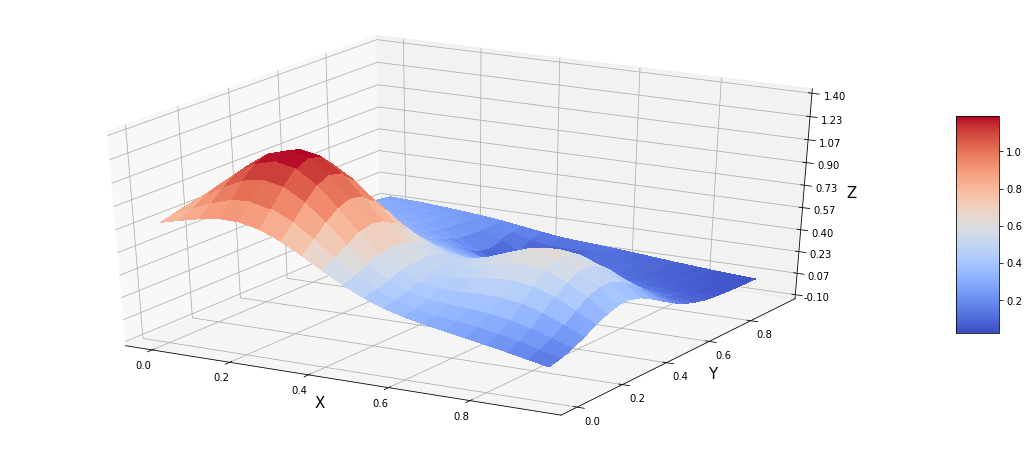

In [7]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0,1,x.shape)
    return term1 + term2 + term3 + term4# + noise


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_zlabel('Z', fontsize=15)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Make design matrix with polynomial degree n

In [8]:
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of columns in beta
    X = np.ones((N,l)) # matrix with N rows, l columns

    for i in range(1,n+1):
        q = int((i)*(i+1)/2) 
        for k in range(i+1): 
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

## OLS regression with polynomial degree 1-5

In [9]:
# Making meshgrid of datapoints and compute Franke's function
n = 5
N = 1000
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)

polydegree = np.zeros(n)
r2_train = np.zeros(n)
r2_test = np.zeros(n)
mse_train = np.zeros(n)
mse_test = np.zeros(n)

# OLS regression for polynomials from 1 to n
for i in range(n):
    n = i+1
    print(n)
    polydegree[i] = n
    X = create_X(x_flat, y_flat, n)
    #X = X - np.mean(X)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    
    # prediction
    betaOLS = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    ztilde_train = X_train @ betaOLS
    ztilde_test = X_test @ betaOLS
    
    # errors
    r2_train[i] = r2_score(z_train, ztilde_train)
    r2_test[i] = r2_score(z_test, ztilde_test)
    mse_train[i] = mean_squared_error(z_train, ztilde_train) #MSE(z_train,ztilde_ols_train)
    mse_test[i] = mean_squared_error(z_test, ztilde_test)  #MSE(z_test,ztilde_ols_test)

1
2
3
4
5


## Plot error as function of complexity

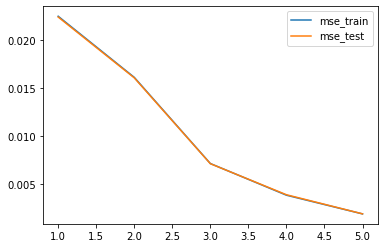

In [10]:
plt.plot(polydegree, mse_train, label='mse_train')
plt.plot(polydegree, mse_test, label='mse_test')
#plt.plot(polydegree, r2_train, label='r2_train')
#plt.plot(polydegree, r2_test, label='r2_test')
plt.legend()
plt.show()

## Make confidence intervals
- $\mu_{\beta} \pm \frac{2\sigma_{\beta}}{\sqrt{n}}$

[  0.36012087   8.105514     3.95904035 -35.13916561 -15.73996349
  -9.16059988  49.55714959  46.13258612  21.14114703  -7.21244023
 -24.61634688 -54.85413246  -8.65563723 -29.70611616  28.39842809
   1.77151024  19.39539971  11.22543054  -5.40637495  16.6916804
 -16.17783564]


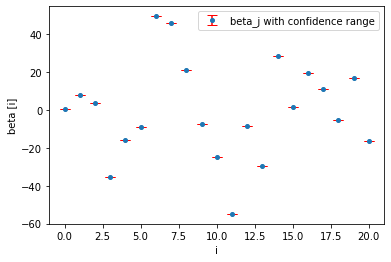

,Beta,+-
0,0.360121,0.000125
1,8.105514,0.001398
2,3.959040,0.001361
3,-35.139166,0.006645
4,-15.739963,0.005102
5,-9.160600,0.006438
6,49.557150,0.014754
7,46.132586,0.010727
8,21.141147,0.010819
9,-7.212440,0.014289


In [11]:
variance = np.zeros(len(betaOLS))
CI = np.zeros(len(betaOLS))

for i in range(len(betaOLS)):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)
print(betaOLS)

plt.errorbar(np.arange(0,len(betaOLS)), betaOLS, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='beta_j with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.legend()
plt.show()

table = pd.DataFrame({'Beta': betaOLS, '+-': CI})
table

# Exercise 2 - Bias-variance trade-off and resampling techniques

## Notes
- scaling or not scaling - no difference as expected (ref notes exercise 1)
- Increasing from 50 bootstraps gives no improved results
- Increasing N from 100 only smoothens the curve
- Polynomial degree above 10 does not decrease errors

## OLS regression with bootstrap 

1
2
3
4
5
6
7
8
9
10


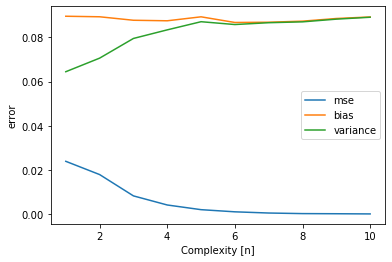

In [12]:
N = 200
n_bootstraps = 30
maxdegree = 10
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

polydegree = np.zeros(maxdegree)
mse_error = np.zeros(maxdegree)
r2_error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
mse_est = np.zeros(maxdegree)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)

for i in range(maxdegree):
    degree = i+1
    print(degree)
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    #X = X - np.mean(X)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    
    mse_bs = np.zeros(n_bootstraps)
    bias_bs = np.zeros(n_bootstraps)
    variance_bs = np.zeros(n_bootstraps)
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train)
        beta = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        z_pred = X_test @ beta
        
        mse_bs[j] = np.mean((z_test - z_pred)**2)
        bias_bs[j] = np.mean((np.mean(z_pred) - z_test)**2) #np.mean((z_test - np.mean(z_pred))**2)
        variance_bs[j] = np.var(z_pred)
    
    mse_error[i] = np.mean(mse_bs)
    bias[i] = np.mean(bias_bs)
    variance[i] = np.mean(variance_bs)
    
    
plt.plot(polydegree, mse_error, label='mse')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='variance')
plt.xlabel('Complexity [n]')
plt.ylabel('error')
plt.legend()
plt.show()

## Discussion on bias-variance trade-off

- Varier polynomgrad n, punkter N og antall bootstraps n_bootstraps og diskuter forskjellene


# Exercise 3 - cross validation as resampling technique, adding more complexity

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

N = 100
degree = 5
k = 10
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
mse_scores = []

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)

kfold = KFold(n_splits = k)

for train_indexes, test_indexes in kfold.split(X):
    #print(train_indexes)

    X_train = X[train_indexes]
    X_test = X[test_indexes]
    z_train = z[train_indexes]
    z_test = z[test_indexes]

    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    print(beta.shape)
    z_pred = X_test @ beta
    mse_scores.append(mean_squared_error(z_test, z_pred))
    #print(mse_scores[i])

print(np.mean(mse_scores))

(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
0.019493721267666252


## CV with scikit cross_val_score

In [14]:
linreg = LinearRegression()
mse_scikit_linreg = cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold)


print(np.mean(mse_scikit_linreg))

-0.019493721255044123


# Exercise 4 - Ridge regression on the Franke function with resampling 

- Ridge: Shrinking beta-coefficients with large variance, but never to zero
- Lasso: Same, but can shrink to zero
- Noisy function means large variance
- To compare OLS/ridge/beta, try to compute coefficients and see with/without noise
- Beta coefficients in ridge are given by Gaussian distribution, in Lasso they are given by Laplace distribution (thats why they can go to zero)

- Scaling: Subtracting the mean value means first column of design matrix (1,1,1,...) becomes zero.

In [15]:
N = 100
degree = 5
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)


nlambdas = 100
n_bootstraps = 50
k = 5
kfold = KFold(n_splits = k)
lambdas = np.logspace(-5, 5, nlambdas)
mse_ridge_bs = np.zeros(nlambdas)
mse_ridge_bs_scikit = np.zeros(nlambdas)
mse_ridge_cv = np.zeros(nlambdas)
bias = np.zeros(nlambdas)
variance = np.zeros(nlambdas)

for i in range(nlambdas):
    lmd = lambdas[i]
    # Cross validation
    mse_cv = []
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]

        beta = np.linalg.pinv(X_train.T @ X_train + lmd*np.eye(X_train.shape[1], X_train.shape[1])) @ X_train.T @ z_train
        z_pred = X_test @ beta
        mse_cv.append(mean_squared_error(z_test, z_pred))
    mse_ridge_cv[i] = np.mean(mse_cv)
    
    
    # Bootstrap
    mse_bs = np.zeros(n_bootstraps)
    mse_bs_scikit = np.zeros(n_bootstraps)
    bias_bs = np.zeros(n_bootstraps)
    variance_bs = np.zeros(n_bootstraps)
    
    for j in range(n_bootstraps):
        X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
        x_bs,z_bs = resample(X_train, z_train)
        beta = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1], x_bs.shape[1])) @ x_bs.T @ z_bs
        z_pred = X_test @ beta
        mse_bs[j] = mean_squared_error(z_test, z_pred)
        bias_bs[j] = np.mean((z_test - np.mean(z_pred))**2)
        variance_bs[j] = np.var(z_pred)
    
    mse_ridge_bs[i] = np.mean(mse_bs)
    bias[i] = np.mean(bias_bs)
    variance[i] = np.mean(variance_bs)

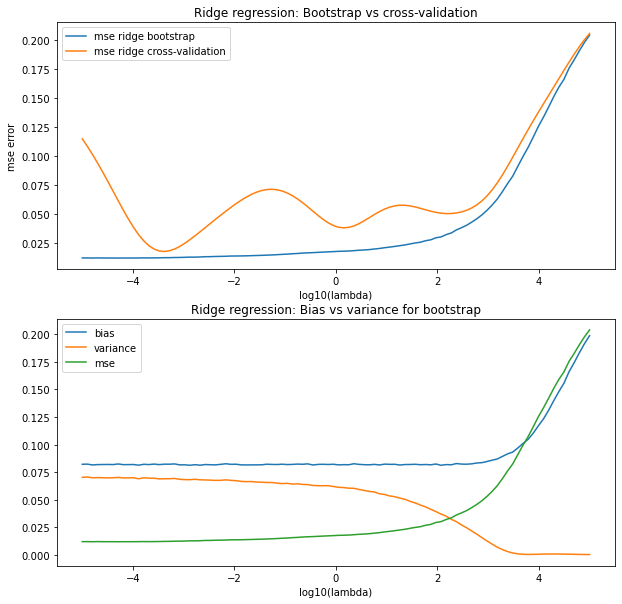

In [17]:
fig,ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(np.log10(lambdas), mse_ridge_bs, label='mse ridge bootstrap')
ax[0].plot(np.log10(lambdas), mse_ridge_cv, label='mse ridge cross-validation')
ax[0].set_xlabel('log10(lambda)')
ax[0].set_ylabel('mse error')
ax[0].legend()
ax[0].set_title('Ridge regression: Bootstrap vs cross-validation')

ax[1].plot(np.log10(lambdas), bias, label='bias')
ax[1].plot(np.log10(lambdas), variance, label='variance')
ax[1].plot(np.log10(lambdas), mse_ridge_bs, label='mse')
ax[1].set_xlabel('log10(lambda)')
ax[1].legend()
ax[1].set_title('Ridge regression: Bias vs variance for bootstrap')
plt.show()

1e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.047615752789664e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.0974987654930568e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.1497569953977357e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.2045035402587812e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.2618568830660211e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.3219411484660286e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.3848863713938746e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.4508287784959402e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.5199110829529332e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.5922827933410938e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.6681005372000593e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.747528400007683e-05
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
1.830

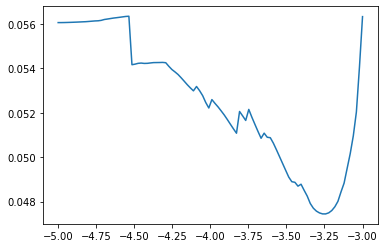

In [18]:
from sklearn.linear_model import Lasso

N = 100
degree = 5
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)


z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)

nlambdas = 100
lambdas = np.logspace(-5, -3, nlambdas)
k = 5
kfold = KFold(n_splits = k)

mse_lasso_bs = np.zeros(nlambdas)
mse_lasso_cv = np.zeros(nlambdas)
bias = np.zeros(nlambdas)
variance = np.zeros(nlambdas)

for i in range(nlambdas):
    lmd = lambdas[i]
    print(lmd)
    # Cross validation
    mse_cv = []
    lassoreg = Lasso(alpha=lmd, normalize = True, tol = 0.1)
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        print(X_test.shape)

        lassoreg.fit(X_train, z_train)
        z_pred = lassoreg.predict(X_test)
        
        mse_cv.append(mean_squared_error(z_test, z_pred))
    mse_lasso_cv[i] = np.mean(mse_cv)

plt.plot(np.log10(lambdas), mse_lasso_cv)
plt.show()

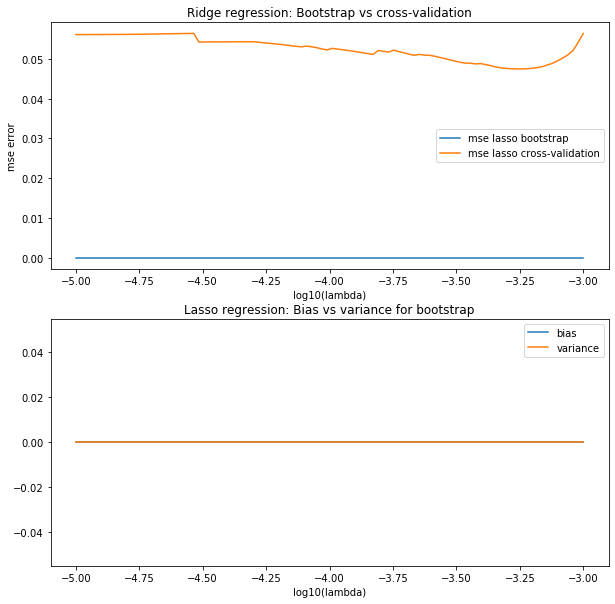

In [20]:
fig,ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(np.log10(lambdas), mse_lasso_bs, label='mse lasso bootstrap')
ax[0].plot(np.log10(lambdas), mse_lasso_cv, label='mse lasso cross-validation')
ax[0].set_xlabel('log10(lambda)')
ax[0].set_ylabel('mse error')
ax[0].legend()
ax[0].set_title('Ridge regression: Bootstrap vs cross-validation')

ax[1].plot(np.log10(lambdas), bias, label='bias')
ax[1].plot(np.log10(lambdas), variance, label='variance')
ax[1].set_xlabel('log10(lambda)')
ax[1].legend()
ax[1].set_title('Lasso regression: Bias vs variance for bootstrap')
plt.show()